# Machine Learning Capstone project

## Data Exploration

For stock price prediction finance data was downloaded from Yahoo finance https://finance.yahoo.com/quote/CSV/history?p=CSV. 

         Date         Open         High          Low        Close  \
0  2017-03-27  2329.110107  2344.899902  2322.250000  2341.590088   
1  2017-03-28  2339.790039  2363.780029  2337.629883  2358.570068   
2  2017-03-29  2356.540039  2363.360107  2352.939941  2361.129883   
3  2017-03-30  2361.310059  2370.419922  2358.580078  2368.060059   
4  2017-03-31  2364.820068  2370.350098  2362.600098  2362.719971   

     Adj Close      Volume  
0  2341.590088  3240230000  
1  2358.570068  3367780000  
2  2361.129883  3106940000  
3  2368.060059  3158420000  
4  2362.719971  3354110000  
Financial dataset has 252 data points with 7 variables each.


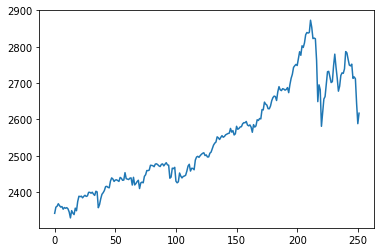

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import matplotlib.pylab as plt
from datetime import datetime

# Import cross validation

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load prices dataset
data = pd.read_csv("GSPC.csv")
prices = data['Adj Close']

ds_length = data.shape[0]

print(data.head())

featuresMy = []
featuresMyNew = []
dates = data['Date']
for date in dates:
    featuresMyNew.append(datetime.strptime(date, '%Y-%m-%d').toordinal())  

for index in range(len(data)):
    featuresMy.append([index])
    
features = pd.Series(featuresMyNew)

testF = data.drop('Date', axis = 1)

# Success
print ("Financial dataset has {} data points with {} variables each.".format(*data.shape))

plt.plot(featuresMy, prices)

## Exploratory Visualization

----

## Developing a Model
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

In [18]:
def test_stationarity(data):
    
    #Determing rolling statistics
    rolmean = data.rolling(window=20,center=False).mean()
    rolmean = data

    #Plot rolling statistics:
    orig = plt.plot(data, color='blue',label='Original line')
    mean = plt.plot(rolmean, color='red', label='With rolling mean')

    plt.title('Rolling Mean')

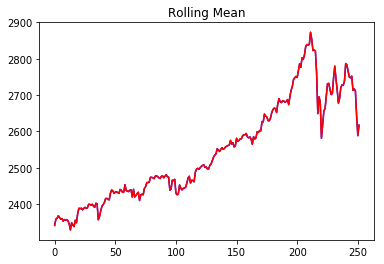

In [19]:
test_stationarity(prices)

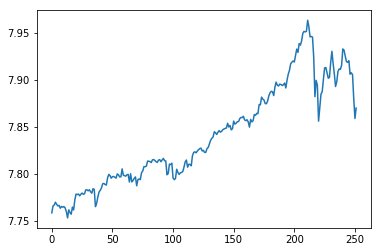

In [20]:
ts_log = np.log(prices)
plt.plot(ts_log)

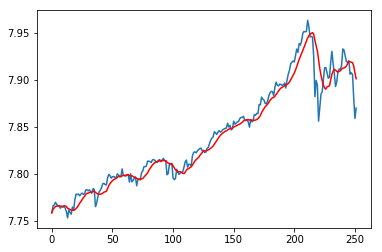

In [21]:
moving_avg = ts_log.rolling(min_periods=1,window=10,center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, you will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [22]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Implementation: Fitting a Model

In [23]:
from sklearn import cross_validation

def test_results(historiacal, forecasted):
    #Plot rolling statistics
    plt.plot(historiacal, color='red', label='Historical')
    plt.plot(forecasted, color='blue', label='Predicted')
    plt.title('Test results')
    plt.show()
    
def get_historical_data_slice(features, labels, start, length):
    localLabels = labels[start:(length+start)]
    localFeatures = []
    for dateInt in features.iloc[start:(length+start)]:
        localFeatures.append([dateInt])
    return localFeatures, localLabels     

def get_prediction_data_slice(features, Y_predicted, regressor, start, length):
    predictedFeature = [features.iloc[length+start+1]]
    predictedPrice = regressor.predict([predictedFeature]) 
    Y_predicted[length+start+1] = predictedPrice[0]
    return Y_predicted

def get_prediction_data_slice_for_NN(features, Y_predicted, NNmodel, start, length):
    predictedFeature = [features.iloc[length+start+1]]
    predictedFeature = np.array([predictedFeature])
    predictedPrice = NNmodel.predict(predictedFeature) 
    Y_predicted[length+start+1] = predictedPrice[0]
    return Y_predicted

# RandomForest regression

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

Y_predict_RFR = np.copy(prices)
prediction_window = 30

for i in range(0, ds_length - prediction_window - 1):
    
    # Get historical data for prediciton
    localFeatures, localPrices = get_historical_data_slice(features, prices, i, prediction_window)
    
    # Split train set
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(localFeatures, localPrices, test_size=0.2, train_size=0.8, random_state=3)
   
    # Train model
    regr = RandomForestRegressor(random_state=0)
    regr.fit(X_train, y_train)
    
    # Getting final prediction
    Y_predict_RFR = get_prediction_data_slice(features, Y_predict_RFR, regr, i, prediction_window)


print("All price calculated")
print("Performance %d", performance_metric(prices, Y_predict_RFR))

All price calculated
('Performance %d', 0.9561447616387699)


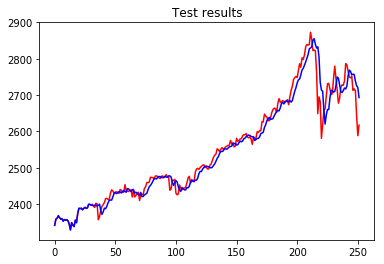

In [25]:
# Trying to predict new valies
test_results(prices, Y_predict_RFR)

# Linear Regression method

In [13]:
from sklearn.linear_model import LinearRegression

Y_predict_LR = np.copy(prices)
prediction_window = 30

for i in range(0, ds_length - prediction_window - 1):
    
    # Get historical data for prediciton
    localFeatures, localPrices = get_historical_data_slice(features, prices, i, prediction_window)
    
    # Split train set
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(localFeatures, localPrices, test_size=0.2, train_size=0.8, random_state=3)
   
    # Train model
    regr = LinearRegression(n_jobs=10,copy_X=False)
    regr.fit(X_train, y_train)
    
    # Getting final prediction
    Y_predict_LR = get_prediction_data_slice(features, Y_predict_LR, regr, i, prediction_window)


print("All price calculated")
print("Performance %d", performance_metric(prices, Y_predict_LR))

All price calculated
('Performance %d', 0.9070163880435794)


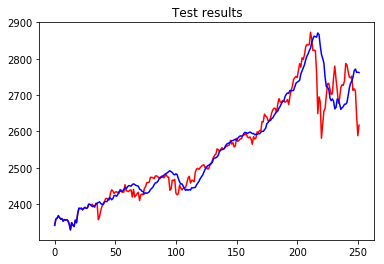

In [12]:
# Trying to predict new valies
test_results(prices, Y_predict_LR)

# KNeighborsRegressor

In [13]:
from sklearn.neighbors import KNeighborsRegressor

Y_predict_KNNR = np.copy(prices)
prediction_window = 30

for i in range(0, ds_length - prediction_window - 1):
    
    # Get historical data for prediciton
    localFeatures, localPrices = get_historical_data_slice(features, prices, i, prediction_window)
    
    # Split train set
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(localFeatures, localPrices, test_size=0.2, train_size=0.8, random_state=3)
   
    # Train model
    regr = KNeighborsRegressor(n_neighbors=2)
    regr.fit(X_train, y_train)
    
    # Getting final prediction
    Y_predict_KNNR = get_prediction_data_slice(features, Y_predict_KNNR, regr, i, prediction_window)


print("All price calculated")
print("Performance %d", performance_metric(prices, Y_predict_KNNR))

All price calculated
('Performance %d', 0.962192442858566)


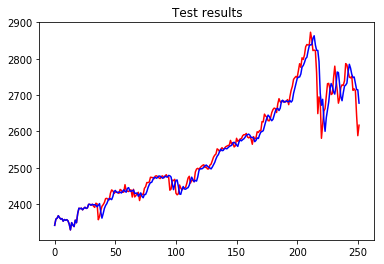

In [14]:
# Trying to predict new valies
test_results(prices, Y_predict_KNNR)

# SVR

In [15]:
from sklearn.svm import SVR

Y_predict_SVR = np.copy(prices)
prediction_window = 30

for i in range(0, ds_length - prediction_window - 1):
    
    # Get historical data for prediciton
    localFeatures, localPrices = get_historical_data_slice(features, prices, i, prediction_window)
    
    # Split train set
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(localFeatures, localPrices, test_size=0.2, train_size=0.8, random_state=3)
   
    # Train model
    regr = SVR()
    regr.fit(X_train, y_train)
    
    # Getting final prediction
    Y_predict_SVR = get_prediction_data_slice(features, Y_predict_SVR, regr, i, prediction_window)


print("All price calculated")
print("Performance %d", performance_metric(prices, Y_predict_SVR))

All price calculated
('Performance %d', 0.8469458525826197)


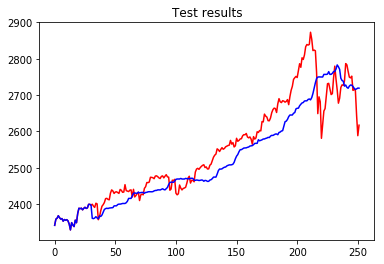

In [16]:
# Trying to predict new valies
test_results(prices, Y_predict_SVR)

# NeuralNetwork Keras 

In [11]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

Y_predict_NNK = np.copy(prices)

# Split train set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, prices, test_size=0.2, train_size=0.8, random_state=3)

# Train model
model = Sequential()
model.add(Dense(250, input_dim=1, init='normal', activation='relu'))
model.add(Dense(1, init='normal', activation='linear'))

print(X_train.shape, y_train.shape)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

print('after reshape')
print(X_train.shape, y_train.shape)

# Compile model
model.compile(loss='mean_absolute_error', optimizer='rmsprop')
model.fit(X_train, y_train, nb_epoch=200, batch_size=25, verbose=0)

Y_predict_NNK = get_prediction_data_slice_for_NN(features, Y_predict_NNK, model, i, prediction_window)

print("All price calculated")
print("Performance %d", performance_metric(prices, Y_predict_NNK))

/Users/dmitrymorozov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(250, activation="relu", kernel_initializer="normal", input_dim=1)`
  # This is added back by InteractiveShellApp.init_path()
/Users/dmitrymorozov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="linear", kernel_initializer="normal")`
  if sys.path[0] == '':


((201,), (201,))
after reshape
((201, 1), (201, 1))
All price calculated
('Performance %d', 0.5405042729512994)


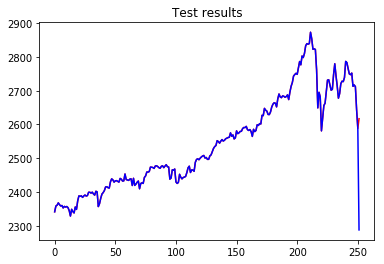

In [24]:
# Trying to predict new valies
test_results(prices, Y_predict_NNK)

# Recurrent Neural Network

In [ ]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

Y_predict_RNNK = np.copy(prices)

# Split train set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, prices, test_size=0.2, train_size=0.8, random_state=3)

# Train model
#need unscaled data for the RNN
colmn = self.data[self.metric]
colmn = colmn.values
print "last 3 cols", colmn[-1]
self.maxlen = 7

#self.step = 1
self.step = self.numBdaysAhead-1

#batch size tuning parameter
self.batch_size = 50
X = []
y = []
# as above, need to create data and labels for the RNN.
for i in range(0, len(colmn) - self.step-self.maxlen):
    X.append(colmn[i: i + self.maxlen])
    y.append(colmn[i + self.step+self.maxlen])
#print('nb sequences:', len(X))

#convert lists to np arrays
X = np.array(X)
y = np.array(y)

#convert to 3D and 2D tensors for processing by RNN
X = np.reshape(X, X.shape + (1,))
y = np.reshape(y, y.shape + (1,))

#print('X_train shape:', X.shape)
#print('X_test shape:', y.shape)

#print "X and y", X[-1], y[-1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=42)

model = Sequential()
model.add(LSTM(50,
               batch_input_shape=(self.batch_size, self.maxlen, 1),
               return_sequences=True))
model.add(LSTM(50,
               batch_input_shape=(self.batch_size, self.maxlen, 1),
               return_sequences=False))
model.add(Dense(1, init='normal', activation='linear'))

print model.summary()
# Compile model
model.compile(loss='mean_absolute_error', optimizer='rmsprop')

model.fit(X_train, y_train, nb_epoch=150, batch_size=25, verbose=0)

predicttest = model.predict(X_test)
predicttrain = model.predict(X_train)

print "R2 score for training set (RNN): {:.4f}.".format(r2_score(predicttrain, y_train))
print "R2 score for test set (RNN): {:.4f}.".format(r2_score(predicttest, y_test))
self.model = model

Y_predict_NNK = get_prediction_data_slice_for_NN(features, Y_predict_NNK, model, i, prediction_window)

print("All price calculated")
print("Performance %d", performance_metric(prices, Y_predict_NNK))